### Introduction
We continue our work, with census data, from [Project 1](https://gist.github.com/kjprice/820c75bd8e5c3f2558f4576f38893dae), to take a deeper look into our data. We move beyond exploratory data analysis and will now look into classifying the data based on the given attributes. 

In [39]:
import pandas as pd
import numpy as np
import sys
import os
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# load in raw dataset
person_raw = pd.read_csv('../data/person-subset-2.5percent.csv')

# clean data (as performed in Project 1)
# will provide us with a new dataset "df"
# ...and a list of "important_features"
execfile('../python/clean_data_person.py')

Let's take a look at some of the `important_features` discovered from the previous project:

In [40]:
df[important_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60357 entries, 0 to 78317
Data columns (total 14 columns):
PINCP     60357 non-null float64
POVPIP    57892 non-null float64
JWMNP     32486 non-null float64
AGEP      60357 non-null int64
PWGTP     60357 non-null int64
PAP       60357 non-null float64
CIT       60357 non-null object
ENG       60357 non-null object
COW       60357 non-null object
PUMA      60357 non-null category
SEX       60357 non-null object
MIL       60357 non-null object
SCHL      60357 non-null float64
MAR       60357 non-null object
dtypes: category(1), float64(5), int64(2), object(6)
memory usage: 6.6+ MB


### New Categorical Variable

Along with these attributes above, as defined in our [previous project](https://gist.github.com/kjprice/820c75bd8e5c3f2558f4576f38893dae), we will want to add another variable which we will use to perform a classification analysis on. This variable should be categorical and would, ideally, continue on with our theme of "predicting income". Income (`PINCP`), as we have it currently, is a continuous variable. We will take income and will create a new categorical variable called `affluency`, which will take on the values "general" and "rich" based on whether the individual makes less (or more) than $100,000:

In [41]:
def create_affluency():
    global lr
    global important_features

    lr = df[important_features].copy(deep=True)
    lr['affluency'] = pd.cut(df.PINCP, [-1, 99999.99, 1e12], labels=('general', 'rich'))
create_affluency()

### Cleanup
Now that we have our new categorical variable, and a new dataset (`lr`) based on our `important_features`, let's try to clean up our data.

First, we will remove unwanted fields:

In [42]:
del lr['POVPIP']
del lr['PINCP']
del lr['PUMA']
del lr['MIL']
del lr['MAR']
del lr['SCHL']

Then we group "Travel Time" (`JWMNP`)

In [43]:
def calculate_travel_time():
    lr.JWMNP = lr.JWMNP.fillna(-1)
    lr['travel_time'] = pd.cut(lr.JWMNP, (-2, 0, 15, 40, 60, lr.JWMNP.max()), labels=['na', 'short', 'half hour', 'hour', 'long'])
    del lr['JWMNP']
calculate_travel_time()

Then, from our variables `affluency` and `SEX`, we will create the boolean variables `wealthy` and `is_male` respectively:

In [44]:
def calculate_bools():
    lr['wealthy'] = lr.affluency == 'rich'
    del lr['affluency']
    lr['is_male'] = lr.SEX == 'Male'
    lr.is_male = lr.is_male.astype(np.int)
    del lr['SEX']
calculate_bools()

Finally, we can perform one-hot-encoding on our other categorical variables `travel_time`, `CIT`, `ENG`, `COW`:

In [45]:
def one_hot_encode():
    global lr
    one_hot_travel_time = pd.get_dummies(lr.travel_time, prefix='Travel_Time_')
    lr = pd.concat((lr, one_hot_travel_time), axis=1)
    del lr['travel_time']

    one_hot_citizenship = pd.get_dummies(lr.CIT, prefix='Citizen_')
    lr = pd.concat((lr, one_hot_citizenship), axis=1)
    del lr['CIT']

    one_hot_english = pd.get_dummies(lr.ENG, prefix='English_')
    lr = pd.concat((lr, one_hot_english), axis=1)
    del lr['ENG']

    one_hot_worker_class = pd.get_dummies(lr.COW, prefix='Worker_Class_')
    lr = pd.concat((lr, one_hot_worker_class), axis=1)
    del lr['COW']
one_hot_encode()

Let's see how our dataset looks now:

In [46]:
lr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60357 entries, 0 to 78317
Data columns (total 30 columns):
AGEP                                               60357 non-null int64
PWGTP                                              60357 non-null int64
PAP                                                60357 non-null float64
wealthy                                            60357 non-null bool
is_male                                            60357 non-null int32
Travel_Time__na                                    60357 non-null uint8
Travel_Time__short                                 60357 non-null uint8
Travel_Time__half hour                             60357 non-null uint8
Travel_Time__hour                                  60357 non-null uint8
Travel_Time__long                                  60357 non-null uint8
Citizen__Born Abroad)                              60357 non-null uint8
Citizen__Naturalized                               60357 non-null uint8
Citizen__Non-Citizen      

Great, so we now we have numeric fields to work with. now we can begin our analysis...

### Prep for Analysis

First, we can create our response `y` and explanatory `X` variables. Then we standardize `X` values. Finally, we split the dataset into a 20/80 testing/training set.

In [47]:
def clean_data_for_analysis():
   global lr2
   ### Create reponse and explanatory variables
   lr2 = lr.copy(deep=True)
   y = lr2.wealthy.values
   del lr2['wealthy']
   X = lr2.values

   ### Standardize X values
   scl_obj = StandardScaler()
   scl_obj.fit(X)
   X = scl_obj.transform(X)
   
   ### Get training/test data
   return train_test_split(X, y, test_size=.2, random_state=0)

In [48]:
X_train, X_test, y_train, y_test = clean_data_for_analysis()

### Logistic Regression

Create a function will analyze our data using a logistic regression.

In [49]:
def run_logistic_regression():
   ### Create reusable logistic regression object
   global lr_clf
   lr_clf = LogisticRegression(penalty='l2', C=0.05, class_weight='balanced', n_jobs=-1)
   
   ### Create and test accuracy of our model
   lr_clf.fit(X_train, y_train)
   y_hat = lr_clf.predict(X_test)
   
   acc = mt.accuracy_score(y_test, y_hat)
   
   print('accuracy: %s \n' % acc)

%time run_logistic_regression()

accuracy: 0.692842942346 

Wall time: 631 ms


### Support Vector Machines

In [50]:
def run_sgd():
   regularize_const = 0.1
   iterations = 5
   svm_sgd = SGDClassifier(alpha=regularize_const, class_weight='balanced',
           fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
           loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l2')
   
   svm_sgd.fit(X_train, y_train)
   y_hat = svm_sgd.predict(X_test)
   
   acc = mt.accuracy_score(y_test, y_hat)
   conf = mt.confusion_matrix(y_test, y_hat)
   
   print('accuracy: %s \n' % acc)

%time run_sgd()

accuracy: 0.666500994036 

Wall time: 82 ms


### Tweak variables

We can try to change our variables to see if we get a different score. Let's see how eduction (`SCHL`), marital status (`MAR`), and military service (`MIL`) affect our model.

In [51]:
create_affluency()
calculate_travel_time()
calculate_bools()
one_hot_encode()

In [52]:
del lr['POVPIP']
del lr['PINCP']
del lr['PUMA']

### Group "education attained"
lr.SCHL = lr.SCHL.fillna(-1)
lr['education_attained'] = pd.cut(lr.SCHL, (-2, 1, 11, 15, 17, 20, 21, 22, 23, 24), labels=['na', 'no_high_school', 'some_high_school', 'HS_diploma', 'some_college', 'bacholors_degree', 'masters_degree', 'professional_degree', 'doctorate_degree'])
del lr['SCHL']


### One-hot-encode our new categorical variables
one_hot_military = pd.get_dummies(lr.MIL, prefix='Miliary_Service_')
lr = pd.concat((lr, one_hot_military), axis=1)
del lr['MIL']

one_hot_education_attained = pd.get_dummies(lr.education_attained, prefix='Education_Attained_')
lr = pd.concat((lr, one_hot_education_attained), axis=1)
del lr['education_attained']

one_hot_marital_status = pd.get_dummies(lr.MAR, prefix="Marital_status_")
lr = pd.concat((lr, one_hot_marital_status), axis=1)
del lr['MAR']

#### Run again


In [53]:

X_train, X_test, y_train, y_test = clean_data_for_analysis()

print('logistic regression:')
%time run_logistic_regression()

print('\n\nsupport vector machine:')
%time run_sgd()

logistic regression:
accuracy: 0.784459907223 

Wall time: 1.92 s


support vector machine:
accuracy: 0.774602385686 

Wall time: 142 ms


Indeed, we see that our accuracy greatly approves with the addition of these several variables

### Advantages between algorithm

We can see that logistic regression gets a better accuracy (about 1%) than support vector machines (using stochastic gradient descent). Logistic regression takes about four times longer, however, than support vector machines. Using a batch gradient descent gives support vectors additional accuracy (consistent with logistic regression) but takes abou three minutes to complete (approximately 250 times slower than logistic regression).

### Interpret the weights

In [54]:
def get_weights():
   zip_vars = zip(lr_clf.coef_.T, lr2.columns) # combine attributes
   zip_vars = sorted(zip_vars)
   
   print('\nWeights of variables')
   for coef, name in zip_vars:
       print(name, 'has weight of', coef[0]) # now print them out

get_weights()


Weights of variables
('Education_Attained__HS_diploma', 'has weight of', -0.39658104784975301)
('Education_Attained__some_high_school', 'has weight of', -0.35910426108900434)
('Worker_Class__nan', 'has weight of', -0.32978564940326538)
('Worker_Class__Unemployeed', 'has weight of', -0.32607924970820107)
('Education_Attained__no_high_school', 'has weight of', -0.31381084465277337)
('Travel_Time__na', 'has weight of', -0.30977338159633522)
('Marital_status__Never Married', 'has weight of', -0.24291596892371856)
('Education_Attained__na', 'has weight of', -0.17876418187388149)
('English__Not at all', 'has weight of', -0.15019718111038075)
('English__Not well', 'has weight of', -0.14470121230967478)
('Worker_Class__State Government', 'has weight of', -0.10874680023206162)
('Education_Attained__some_college', 'has weight of', -0.053094833090232982)
('Marital_status__Separated', 'has weight of', -0.043453441183019831)
('Worker_Class__Local Government', 'has weight of', -0.039996795112794352

Age has the greatest weight.  Education was the second highest weight with both positive and negative impacts on the wealth outcome.  

### Graph the weights

AGEP                                               0.612571
PWGTP                                              0.031558
PAP                                                0.056083
is_male                                            0.546627
Travel_Time__na                                   -0.309773
Travel_Time__short                                 0.054067
Travel_Time__half hour                             0.166518
Travel_Time__hour                                  0.159484
Travel_Time__long                                  0.151056
Citizen__Born Abroad)                              0.002644
Citizen__Naturalized                               0.034100
Citizen__Non-Citizen                              -0.025395
Citizen__US Born                                  -0.004746
Citizen__US Territory Born                        -0.015536
English__Not at all                               -0.150197
English__Not well                                 -0.144701
English__Speaks only English            

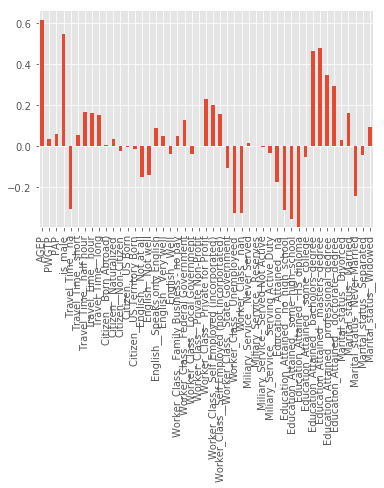

In [55]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(lr_clf.coef_[0],index=lr2.columns)
print weights
weights.plot(kind='bar')
plt.show()

('SVM:', 0.78263750828363154)
0:04:25.737000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22707 entries, 1 to 62664
Data columns (total 48 columns):
AGEP                                               22707 non-null int64
PWGTP                                              22707 non-null int64
PAP                                                22707 non-null float64
wealthy                                            22707 non-null bool
is_male                                            22707 non-null int32
Travel_Time__na                                    22707 non-null uint8
Travel_Time__short                                 22707 non-null uint8
Travel_Time__half hour                             22707 non-null uint8
Travel_Time__hour                                  22707 non-null uint8
Travel_Time__long                                  22707 non-null uint8
Citizen__Born Abroad)                              22707 non-null uint8
Citizen__Naturalized                               22

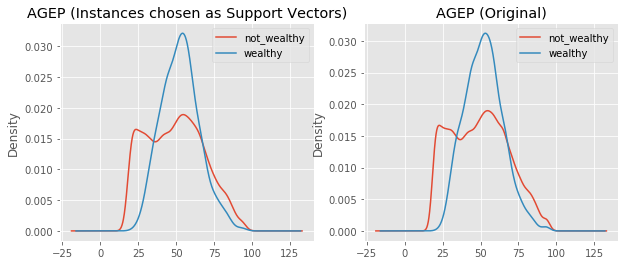

In [56]:
from sklearn.svm import SVC
from datetime import datetime
startTime = datetime.now()

lr2 = lr.copy(deep=True)
y = lr2.wealthy.values
X = lr2.values

svm_clf = SVC(C=0.5, class_weight='balanced')
svm_clf.fit(X_train, y_train)

y_hat = svm_clf.predict(X_test)

conf = mt.confusion_matrix(y_test, y_hat)
acc = mt.accuracy_score(y_test,y_hat)

print('SVM:', acc)
print (datetime.now() - startTime)

# make a dataframe of the training data
# df_tested_on = pd.DataFrame(X_train) # saved from above, the indices chosen for training
df_tested_on = lr2
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support.loc[:,'wealthy'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
lr2.loc[:,'wealthy'] = y # also add it back in for the original data
df_support.info()


# now lets see the statistics of these attributes
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['wealthy'])
df_grouped = lr2.groupby(['wealthy'])

# plot KDE of Different variables
vars_to_plot = ['AGEP']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['not_wealthy','wealthy'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['not_wealthy','wealthy'])
    plt.title(v+' (Original)')




### Support Vectors

Support Vector Machines utilize machine learning algorithms to predict the separation of response variables in training data.  The accurracy of the machine learning is then 